In [1]:
%matplotlib inline
import tensorflow as tf
import sys  
sys.path.insert(0, './')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Local Libraries
from LINA import LINA_Network
tf.compat.v1.disable_eager_execution()

/home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

# 1. Generate Data

In [186]:
def generate_data(n_examples,n_features):
        data = np.random.uniform(
            -1, 1, size=(n_examples, n_features))
        y = (-20*np.sin(2*data[:, 0]*data[:, 1]+data[:, 7])
                                  + 2*np.abs(data[:, 2])
                                  + 4*data[:, 3]*data[:, 4]
                                  - np.exp(-data[:, 5])
                                  ).reshape(-1, 1)
        return data,y

In [187]:
X,Y=generate_data(10000,10)

(array([ 339., 1209., 1184., 1082., 1012., 1034., 1111., 1184., 1309.,
         536.]), array([-24.99001129, -20.10795431, -15.22589732, -10.34384033,
         -5.46178335,  -0.57972636,   4.30233063,   9.18438762,
         14.0664446 ,  18.94850159,  23.83055858]), <a list of 10 Patch objects>)

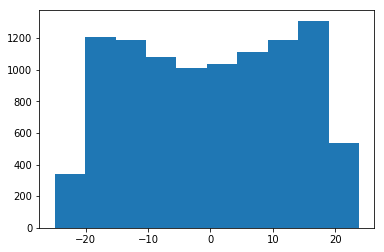

In [188]:
plt.hist(Y)

# 2. Prepare Training,Validation,Testing sets

In [189]:
x=X[:X.shape[0]*80//100,:]
x_test=X[X.shape[0]*80//100:,:]
y=Y[:X.shape[0]*80//100,:]
y_test=Y[X.shape[0]*80//100:,:]

# 3. Set some metrics

In [190]:
def rsquare(y_true,y_pred):
    return 1-tf.keras.losses.MSE(y_true,y_pred)/tf.square(tf.keras.backend.std(y_true))
def rmse(y_true,y_pred):
    return tf.math.sqrt(tf.keras.losses.MSE(y_true,y_pred))

# 4. Train the model


In [191]:
epoch=100
model_layers=(140,60,30,20,)
tf.reset_default_graph()
#Model
gamma=0.000001
beta=0.0001
x_train, x_val = x[:x.shape[0]*80//100], x[x.shape[0]*80//100:]
y_train, y_val = y[:x.shape[0]*80//100], y[x.shape[0]*80//100:]


#Create the model
inputs=tf.keras.Input(shape=(x_train.shape[1],))
network=LINA_Network(num_feature=x_train.shape[1],list_reduc=model_layers,l2_strength=beta,dropout_act=False,classification=False,bn=True)
p,logit,A_tensor,dA_dx_tensor,dy_dx_tensor=network(inputs)
model=tf.keras.Model(inputs,p)

#losses
def loss_with_custom_regularization(y_true, y_pred):
    cross_entropy=tf.keras.losses.MSE(y_true, y_pred)
    a_regularization=tf.math.scalar_mul(gamma,tf.reduce_sum(tf.abs(A_tensor-1)))
    loss_loc=cross_entropy+a_regularization
    return loss_loc

def loss_classic(y_true, y_pred):
    loss_loc=tf.keras.losses.MSE(y_true, y_pred)
    return loss_loc

filepath="./model.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss_classic',verbose=0, save_best_only=True, mode='min',save_weights_only=True)
csv=tf.keras.callbacks.CSVLogger('model.log')
callbacks_list = [checkpoint,csv]
adam = tf.keras.optimizers.Adam(lr = 0.1)
model.compile(loss=loss_with_custom_regularization,optimizer=adam,metrics=[loss_classic,rmse,rsquare])

#Train Model
print("Training...")
model.fit(x_train, y_train, validation_data=(x_val, y_val),callbacks=callbacks_list, epochs=epoch, batch_size=512,verbose=True)

#get the best model back
model.load_weights(filepath)
print("Training done!")
model.evaluate(x_test, y_test)


A_model=tf.keras.Model(inputs,A_tensor)
dy_dx_model=tf.keras.Model(inputs,dy_dx_tensor)
dA_dx_model=tf.keras.Model(inputs,dA_dx_tensor)

#Get the values
A_values=A_model.predict(x_test)
A_jacobian_values=np.array(dA_dx_model.predict(x_test))
dy_dx_values=dy_dx_model.predict(x_test)
K_values=network.logit.get_weights()


Training...
Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 3s 503us/sample - loss: 103.1154 - loss_classic: 103.1079 - rmse: 8.6457 - rsquare: 0.3609 - val_loss: 149155.0656 - val_loss_classic: 149154.7344 - val_rmse: 288.7096 - val_rsquare: -914.8935
Epoch 2/100
6400/6400 [==============================] - 1s 146us/sample - loss: 20.5901 - loss_classic: 20.5780 - rmse: 3.4875 - rsquare: 0.8720 - val_loss: 72588.2084 - val_loss_classic: 72587.9375 - val_rmse: 203.9247 - val_rsquare: -444.2130
Epoch 3/100
6400/6400 [==============================] - 1s 98us/sample - loss: 8.4381 - loss_classic: 8.4252 - rmse: 2.1790 - rsquare: 0.9479 - val_loss: 29784.7105 - val_loss_classic: 29784.5391 - val_rmse: 123.9814 - val_rsquare: -181.4955
Epoch 4/100
6400/6400 [==============================] - 0s 55us/sample - loss: 4.7179 - loss_classic: 4.7050 - rmse: 1.5717 - rsquare: 0.9707 - val_loss: 8050.1547 - val_loss_classic: 8050.0649 - val_

6400/6400 [==============================] - 0s 42us/sample - loss: 0.6772 - loss_classic: 0.6656 - rmse: 0.6066 - rsquare: 0.9959 - val_loss: 10.1388 - val_loss_classic: 10.1258 - val_rmse: 2.6352 - val_rsquare: 0.9379
Epoch 71/100
6400/6400 [==============================] - 0s 48us/sample - loss: 0.9520 - loss_classic: 0.9404 - rmse: 0.6985 - rsquare: 0.9942 - val_loss: 10.7065 - val_loss_classic: 10.6936 - val_rmse: 2.4961 - val_rsquare: 0.9345
Epoch 72/100
6400/6400 [==============================] - 0s 34us/sample - loss: 0.7754 - loss_classic: 0.7638 - rmse: 0.6501 - rsquare: 0.9953 - val_loss: 9.8276 - val_loss_classic: 9.8148 - val_rmse: 2.3401 - val_rsquare: 0.9397
Epoch 73/100
6400/6400 [==============================] - 1s 83us/sample - loss: 0.8542 - loss_classic: 0.8425 - rmse: 0.6606 - rsquare: 0.9948 - val_loss: 9.1434 - val_loss_classic: 9.1308 - val_rmse: 2.1456 - val_rsquare: 0.9440
Epoch 74/100
6400/6400 [==============================] - 0s 49us/sample - loss: 0.91

# 5. Get Values of Interest

In [200]:
'''-20*np.sin(2*X1*X2+X8)+ 2*np.abs(X3)+ 4*X4*X5- np.exp(-X6)'''

'-20*np.sin(2*X1*X2+X8)+ 2*np.abs(X3)+ 4*X4*X5- np.exp(-X6)'

## 5.1 Get Values of Interest Model Wise

In [198]:
#Get Importances
columns=["x"+str(count+1) for count in range(x_train.shape[1])]
derivA_tot=[]
for j in range(x_test.shape[1]):
    sum_tot=K_values[0][:,0][j]*A_values[:,j]
    for k in range(x_test.shape[1]):
        sum_tot+=K_values[0][:,0][k]*A_jacobian_values[k,:,j]*x_test[:,k]
    derivA_tot.append(np.mean(np.abs(sum_tot)))

    
#Print Importances
feature_ranked=[]
for i in np.argsort(derivA_tot)[::-1]:
    feature_ranked.append(columns[i])
features_values={}
for i in range(len(derivA_tot)):
    features_values[columns[i]]=derivA_tot[i]
print("Feature Importances:",dict(sorted(features_values.items(), key=lambda item: item[1],reverse=True)))
print("\n")
#Get Interactions
all_inter=[]
data_tot=[]
strengths={}
for i in range(x_train.shape[1]):
    for j in range(i+1,x_train.shape[1]):
        strengths["x"+str(i+1)+",x"+str(j+1)]=np.mean(np.abs(K_values[0][i,0]*A_jacobian_values[i,:,j]+K_values[0][j,0]*A_jacobian_values[j,:,i]),axis=0)

#Sort results and print Interactions     
topk_inter=dict(sorted(strengths.items(), key=lambda item: item[1],reverse=True))
print("Feature Interactions:")
print(topk_inter)

Feature Importances: {'x1': 15.60287, 'x2': 15.25648, 'x8': 14.563858, 'x5': 2.4373538, 'x4': 2.3859043, 'x3': 2.1120348, 'x6': 1.0976211, 'x9': 0.18200284, 'x7': 0.14876302, 'x10': 0.10126297}


Feature Interactions:
{'x1,x2': 27.922777, 'x1,x8': 10.089996, 'x2,x8': 9.660543, 'x4,x5': 4.4089317, 'x1,x5': 1.1890814, 'x2,x3': 1.1735195, 'x1,x3': 1.1656184, 'x1,x4': 1.0764585, 'x2,x4': 1.0182382, 'x2,x5': 0.9568363, 'x3,x8': 0.8902999, 'x4,x8': 0.7763662, 'x5,x8': 0.65677476, 'x3,x4': 0.5516539, 'x3,x5': 0.45929167, 'x6,x8': 0.4010238, 'x2,x6': 0.397225, 'x1,x6': 0.3653586, 'x8,x9': 0.23825678, 'x2,x7': 0.20970607, 'x2,x9': 0.18354887, 'x1,x9': 0.17468007, 'x7,x8': 0.12749225, 'x4,x6': 0.124263875, 'x1,x7': 0.11853514, 'x5,x6': 0.111195534, 'x8,x10': 0.09822282, 'x1,x10': 0.086221546, 'x2,x10': 0.079726644, 'x4,x7': 0.06608707, 'x5,x7': 0.0656311, 'x5,x9': 0.057361405, 'x5,x10': 0.05386252, 'x4,x9': 0.047952622, 'x4,x10': 0.036822796, 'x3,x6': 0.034314122, 'x3,x9': 0.027441563, 'x3,x7': 

## 5.2 Get Values of Interest Instance Wise

In [199]:
#Get Importances
instance=50
columns=["x"+str(count+1) for count in range(x_train.shape[1])]
derivA_tot=[]
for j in range(x_test.shape[1]):
    sum_tot=K_values[0][:,0][j]*A_values[instance,j]
    for k in range(x_test.shape[1]):
        sum_tot+=K_values[0][:,0][k]*A_jacobian_values[k,instance,j]*x_test[instance,k]
    derivA_tot.append(np.abs(sum_tot))

    
#Print Importances
feature_ranked=[]
for i in np.argsort(derivA_tot)[::-1]:
    feature_ranked.append(columns[i])
features_values={}
for i in range(len(derivA_tot)):
    features_values[columns[i]]=derivA_tot[i]
print("Feature Importances Instance:",dict(sorted(features_values.items(), key=lambda item: item[1],reverse=True)))
print("\n")
#Get Interactions
all_inter=[]
data_tot=[]
strengths={}
for i in range(x_train.shape[1]):
    for j in range(i+1,x_train.shape[1]):
        strengths["x"+str(i+1)+",x"+str(j+1)]=np.abs(K_values[0][i,0]*A_jacobian_values[i,instance,j]+K_values[0][j,0]*A_jacobian_values[j,instance,i])
#Sort results and print Interactions     
topk_inter=dict(sorted(strengths.items(), key=lambda item: item[1],reverse=True))
print("Feature Interactions Instance:")
print(topk_inter)

Feature Importances Instance: {'x8': 21.515720154856222, 'x1': 20.96426279547158, 'x5': 4.4477916008754175, 'x3': 2.915674250028312, 'x4': 1.9255991461788886, 'x6': 1.6438706653015394, 'x2': 1.51338001411221, 'x7': 0.2409585071447216, 'x10': 0.13361849468329573, 'x9': 0.04456344370715947}


Feature Interactions Instance:
{'x1,x2': 50.39241, 'x4,x5': 5.300459, 'x2,x8': 4.3560123, 'x1,x8': 3.4556975, 'x2,x3': 3.0945563, 'x1,x4': 1.9398233, 'x3,x8': 1.6308753, 'x4,x8': 1.4843621, 'x3,x5': 1.1157187, 'x3,x4': 0.9667753, 'x1,x5': 0.816437, 'x6,x8': 0.7960988, 'x1,x6': 0.68383706, 'x5,x8': 0.51972514, 'x2,x7': 0.50811803, 'x5,x6': 0.46610478, 'x1,x3': 0.448335, 'x8,x9': 0.35809895, 'x2,x4': 0.3545314, 'x2,x9': 0.33640534, 'x2,x5': 0.32252577, 'x4,x6': 0.27049884, 'x1,x10': 0.16085628, 'x1,x9': 0.13356012, 'x4,x7': 0.12827723, 'x1,x7': 0.11663456, 'x2,x10': 0.09953439, 'x3,x6': 0.08500106, 'x5,x7': 0.08280718, 'x4,x10': 0.0692056, 'x7,x8': 0.06158585, 'x8,x10': 0.053611908, 'x5,x10': 0.050942